In [1]:
# imports
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore") # may not always be the best thing to do...

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

### Introduction - Initial contact with the data

In [2]:
# Importing our data
x_train = pd.read_csv("X_train_6GWGSxz.csv")
x_test = pd.read_csv("X_test_c2uBt2s.csv")
y_train = pd.read_csv("y_train_2G60rOL.csv")

In [3]:
print(x_train.shape, y_train.shape)
x_train.head()

(417599, 10) (417599, 5)


,time_step,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure,Unnamed: 9
0,2013-03-17T00:01:00.0,550.4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-03-17T00:02:00.0,548.6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-03-17T00:03:00.0,549.3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-03-17T00:04:00.0,549.3667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-03-17T00:05:00.0,548.8909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
y_train.head()

,time_step,washing_machine,fridge_freezer,TV,kettle
0,2013-03-17T00:01:00.0,0.0,79.2000,7.0,0.0
1,2013-03-17T00:02:00.0,0.0,78.0000,7.0,0.0
2,2013-03-17T00:03:00.0,0.0,76.9000,7.0,0.0
3,2013-03-17T00:04:00.0,0.0,76.1111,7.0,0.0
4,2013-03-17T00:05:00.0,0.0,75.2727,7.0,0.0


Our objective is to predict an array of electronic equipment consumptions based on overall consumption for our home and weather indications, to implement "non-intrusive" monitoring methods.  
We aim to predict a fraction of electric consumption by appliance. 

In [5]:
x_train.describe()

,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure,Unnamed: 9
count,407368.000000,6936.000000,6947.000000,6936.000000,6936.000000,6928.000000,6936.000000,6932.000000,1.0
mean,303.604240,23.817647,10.861293,82.966984,11.751153,9.331207,13.250433,1009.834550,4.0
std,343.624792,13.898124,4.681409,13.754116,5.471570,5.424768,7.976118,48.069813,NaN
min,106.000000,0.000000,-4.400000,26.000000,-4.400000,-5.900000,0.000000,1.000000,4.0
25%,158.000000,13.000000,7.600000,74.000000,7.600000,5.400000,7.000000,1005.400000,4.0
50%,192.000000,23.000000,10.900000,86.000000,11.600000,9.400000,13.000000,1013.200000,4.0
75%,312.250000,35.000000,14.100000,94.000000,15.700000,13.200000,19.000000,1019.200000,4.0
max,7571.222200,75.000000,27.800000,100.000000,30.700000,27.800000,52.000000,1039.500000,4.0


In [6]:
y_train.describe()

,washing_machine,fridge_freezer,TV,kettle
count,407368.000000,407368.000000,407368.000000,407368.000000
mean,5.549846,49.788985,14.566326,4.945594
std,56.893803,52.852856,17.514445,104.781433
min,0.000000,0.000000,3.500000,0.000000
25%,0.000000,0.000000,7.000000,0.000000
50%,0.000000,58.750000,7.000000,0.000000
75%,0.000000,87.400000,7.000000,0.000000
max,2430.600000,566.500000,109.500000,3084.000000


In [7]:
x_train.isna().sum()

time_step           0
consumption     10231
visibility     410663
temperature    410652
humidity       410663
humidex        410663
windchill      410671
wind           410663
pressure       410667
Unnamed: 9     417598
dtype: int64

One of our key challenges will be the high occurrence of missing datapoints in our frame.  
All variables except consumption and unnamed seem to have approxiately the same number of missing values, potentially indicating a pattern in the missing data.

In [8]:
# The missing values in overall consumption entail missing values for each equipment
y_train.isna().sum()

time_step              0
washing_machine    10231
fridge_freezer     10231
TV                 10231
kettle             10231
dtype: int64

In [9]:
# Creating a training dataframe for data exploration
data = pd.concat([x_train,y_train],axis=1,sort=False)
data = data.loc[:,"consumption":"kettle"] # duplicate time_steps otherwise
data.head()

,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure,Unnamed: 9,time_step,washing_machine,fridge_freezer,TV,kettle
0,550.4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-03-17T00:01:00.0,0.0,79.2000,7.0,0.0
1,548.6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-03-17T00:02:00.0,0.0,78.0000,7.0,0.0
2,549.3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-03-17T00:03:00.0,0.0,76.9000,7.0,0.0
3,549.3667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-03-17T00:04:00.0,0.0,76.1111,7.0,0.0
4,548.8909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-03-17T00:05:00.0,0.0,75.2727,7.0,0.0


In [75]:
mask = data["consumption"].isna()
data[mask].isna().sum()

consumption        10231
visibility         10080
temperature        10080
humidity           10080
humidex            10080
windchill          10080
wind               10080
pressure           10080
Unnamed: 9         10231
time_step              0
washing_machine    10231
fridge_freezer     10231
TV                 10231
kettle             10231
dtype: int64

Missing values in consumption entail missing values in y_train.  
This could cause us to delete such observations at least temporarily since they are missing information on all variables and represent only 2.4% of the dataset.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a21922da0>,
      dtype=object)

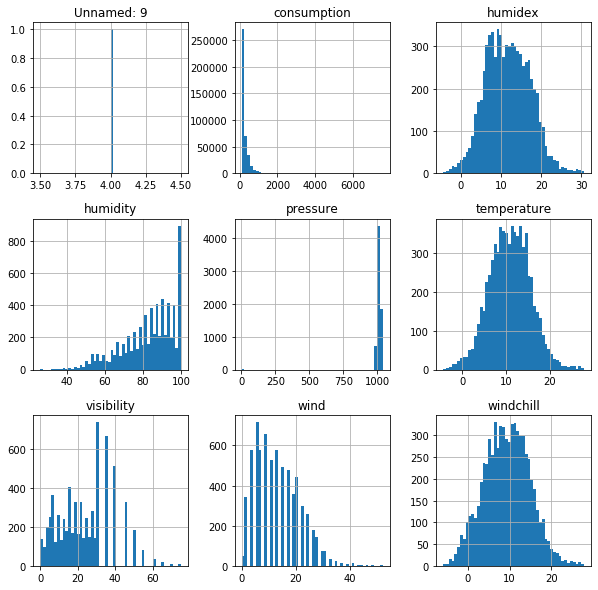

In [76]:
# Getting a first look at the training data
x_train.hist(bins=50, figsize=(10,10))

3 weather variables seem to have near normal distributions: humidex, temperature, windchill.  
We could use simulations of normal distributions with same mean and variance to fill in their missing values. 

###### Investigating consumption as a driver

Our intuition is that consumption will be one of the best predictors for the output consumptions

In [86]:
# Dropping unnamed since the NaNs created errors in the correlation matrix
corr_matrix = data.drop(columns={"Unnamed: 9"}).corr()
corr_matrix.style.background_gradient(cmap='BuPu').set_precision(2)

,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure,washing_machine,fridge_freezer,TV,kettle
consumption,1,0.029,-0.056,0.0019,-0.061,-0.062,0.019,-0.068,0.21,0.12,0.18,0.39
visibility,0.029,1,0.019,-0.46,-0.029,-0.021,0.16,-0.016,-0.013,-0.012,0.013,0.0054
temperature,-0.056,0.019,1,-0.51,0.99,0.98,0.084,0.044,0.0021,0.072,-0.019,-0.0092
humidity,0.0019,-0.46,-0.51,1,-0.42,-0.46,-0.26,-0.04,-0.0097,0.00083,-0.02,0.00097
humidex,-0.061,-0.029,0.99,-0.42,1,0.97,0.058,0.045,0.00059,0.079,-0.02,-0.011
windchill,-0.062,-0.021,0.98,-0.46,0.97,1,-0.1,0.061,0.0036,0.074,-0.025,-0.01
wind,0.019,0.16,0.084,-0.26,0.058,-0.1,1,-0.078,-0.017,-0.0084,0.021,0.002
pressure,-0.068,-0.016,0.044,-0.04,0.045,0.061,-0.078,1,0.0038,-0.0041,-0.015,-0.033
washing_machine,0.21,-0.013,0.0021,-0.0097,0.00059,0.0036,-0.017,0.0038,1,0.0021,-0.012,-0.0022
fridge_freezer,0.12,-0.012,0.072,0.00083,0.079,0.074,-0.0084,-0.0041,0.0021,1,0.017,0.01


It would seem that our intuition is confirmed: the highest correlations with our output {washing_machine, fridge_freezer, TV, kettle} is for consumption.  
Other variables are only lightly correlated to our output, but our correlation matrix does not take interactions into account so we will have to study this.  
Note that as we could expect from the way windchill is constructed, temperature, humidex and windchill are in fact very highly correlated: we might not need all those variables as predictors, and another way of filling missing values is to fit a linear model on one of the variables to predict the others when possible.

In [73]:
corr_matrix["consumption"].sort_values(ascending=False)

consumption        1.000000
kettle             0.388482
washing_machine    0.206889
TV                 0.183381
fridge_freezer     0.119655
visibility         0.028942
wind               0.018537
humidity           0.001947
temperature       -0.056331
humidex           -0.061327
windchill         -0.061684
pressure          -0.068219
Name: consumption, dtype: float64

Simply visualising the correlation of our outputs to the predictor 'consumption'.

In [133]:
# Consumption data is very fragmented (the most frequent value represents only 0.8% of the datapoints) 
# It presents a wide range of values: [166,2326]
data["consumption"].value_counts()[data["consumption"].value_counts()>400]

166.0    3399
152.0    2436
138.0    1529
145.0    1280
159.0    1278
156.0     717
153.0     715
155.0     713
160.0     691
157.0     675
154.0     657
158.0     603
162.0     529
151.0     521
161.0     515
163.0     510
164.0     494
159.5     480
147.0     471
165.0     453
153.5     447
144.0     444
152.5     444
167.0     439
149.0     438
172.0     434
150.0     431
155.5     430
148.0     428
154.5     425
158.5     423
173.0     412
142.0     407
156.5     407
157.5     406
Name: consumption, dtype: int64

We find most values within the [150,165] range.

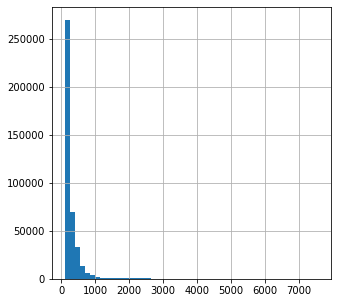

In [110]:
# A very large majority of values are located within the [0,500] range
data["consumption"].hist(bins=50, figsize=(5,5))

##### Humidex, temperature, windchill: confirm or infirm normality

Given the extremely high correlations we found between these three variables, we also expect their distributions to be quite similar at least in shape.

11.8 5.5


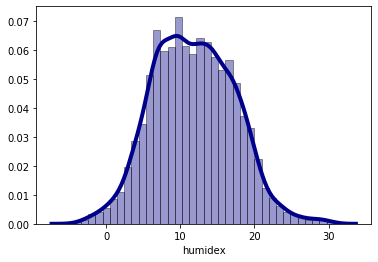

In [49]:
print("%.2f"%np.nanmean(data["humidex"]), "%.2f"%np.nanstd(data["humidex"]))
sns_plot = sns.distplot(data.loc[:,"humidex"], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
fig = sns_plot.get_figure()

10.89 4.69


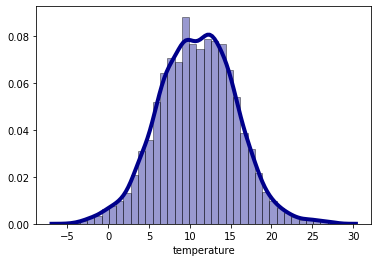

In [50]:
print("%.2f"%np.nanmean(data["temperature"]), "%.2f"%np.nanstd(data["temperature"]))
sns_plot = sns.distplot(data.loc[:,"temperature"], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
fig = sns_plot.get_figure()

9.37 5.43


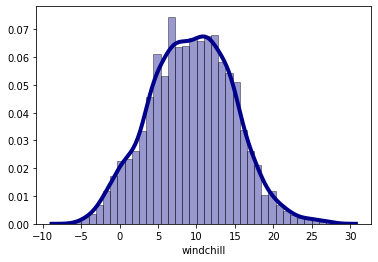

In [51]:
print("%.2f"%np.nanmean(data["windchill"]), "%.2f"%np.nanstd(data["windchill"]))
sns_plot = sns.distplot(data.loc[:,"windchill"], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
fig = sns_plot.get_figure()

#### Investigating wind and humidity together

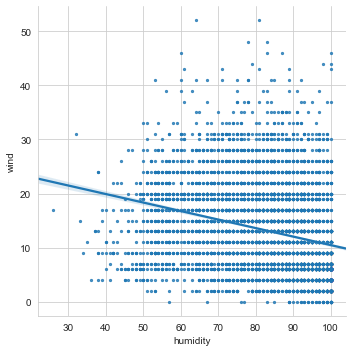

In [112]:
# Wind and humidity
sns.set_style("whitegrid")
sns_plot = sns.lmplot(x = "humidity",
           y = "wind", 
           data = data, 
           fit_reg = True, 
           legend = True, 
           scatter_kws={"s": 5})

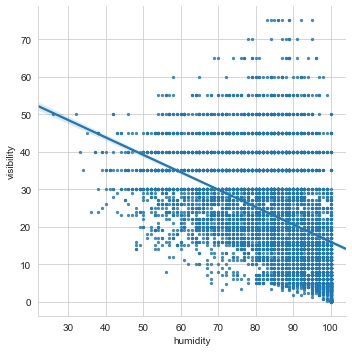

In [113]:
# Visibility and humidity
sns.set_style("whitegrid")
sns_plot = sns.lmplot(x = "humidity",
           y = "visibility", 
           data = data, 
           fit_reg = True, 
           legend = True, 
           scatter_kws={"s": 5})

#### Investigating pressure as a standalone

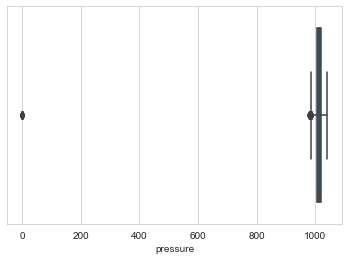

In [126]:
sns.boxplot(data["pressure"])

In [125]:
mask = data["pressure"]<250
data[mask]

,time_step,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure,Unnamed: 9,time_step,washing_machine,fridge_freezer,TV,kettle
11699,2013-03-25T03:00:00.0,550.9000,27.0,6.1,65.0,6.1,2.0,24.0,1.0,NaN,2013-03-25T03:00:00.0,0.000,88.9000,7.0000,0.0000
29219,2013-04-06T07:00:00.0,250.5000,5.0,10.2,100.0,11.5,8.3,13.0,1.0,NaN,2013-04-06T07:00:00.0,0.000,0.0000,7.0000,0.0000
71879,2013-05-05T22:00:00.0,216.8000,21.0,12.4,67.0,12.4,10.7,15.0,1.0,NaN,2013-05-05T22:00:00.0,0.400,0.0000,7.0000,0.0000
74639,2013-05-07T20:00:00.0,336.6000,5.0,8.4,96.0,8.7,6.5,11.0,1.0,4.0,2013-05-07T20:00:00.0,0.000,0.0000,7.0000,0.0000
215279,2013-08-13T12:00:00.0,202.0000,35.0,16.3,70.0,17.9,15.0,22.0,1.0,NaN,2013-08-13T12:00:00.0,0.000,0.0000,7.0000,0.0000
220979,2013-08-17T11:00:00.0,246.5000,35.0,12.5,79.0,13.3,10.1,24.0,1.0,NaN,2013-08-17T11:00:00.0,0.000,170.9000,7.0000,0.0000
307499,2013-10-16T13:00:00.0,225.3333,30.0,12.2,88.0,13.5,10.0,20.0,1.0,NaN,2013-10-16T13:00:00.0,0.000,0.0000,7.0000,0.0000
307739,2013-10-16T17:00:00.0,208.1111,21.0,12.3,88.0,13.6,10.1,20.0,1.0,NaN,2013-10-16T17:00:00.0,0.000,0.0000,7.0000,0.0000
312059,2013-10-19T17:00:00.0,170.6250,35.0,12.2,88.0,13.5,9.9,22.0,1.0,NaN,2013-10-19T17:00:00.0,0.375,0.0000,18.8750,0.0000
330839,2013-11-01T18:00:00.0,2695.2500,10.0,11.4,86.0,12.2,9.1,19.0,1.0,NaN,2013-11-01T18:00:00.0,0.000,164.6250,30.0000,0.0000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x126060240>,
      dtype=object)

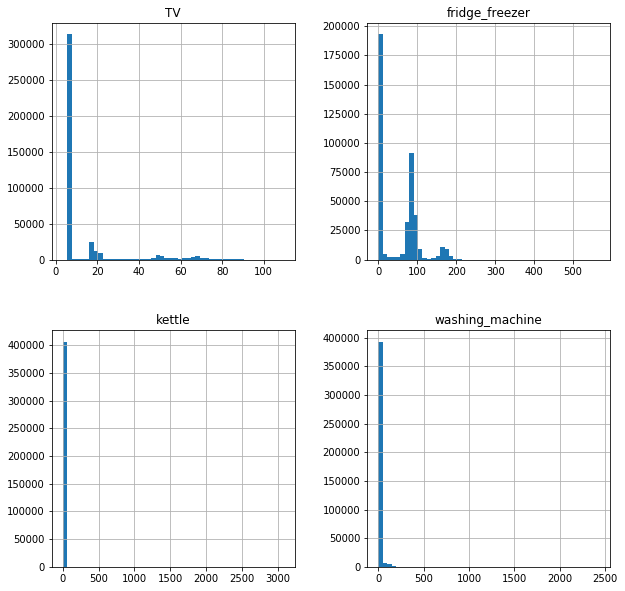

In [30]:
# Getting a first look at the output
%matplotlib inline
y_train.hist(bins=50, figsize=(10,10))

Mean 4.95 Median 0.00


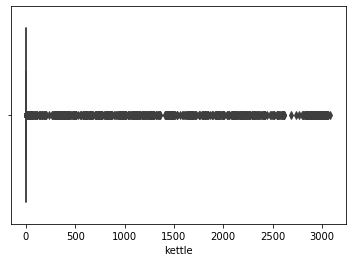

In [63]:
print("Mean","%.2f"%np.nanmean(data["kettle"]), "Median","%.2f"%np.nanmedian(data["kettle"]) )
sns.boxplot(x=data["kettle"])

#### Investigating outputs relatively to one another: we want to predict appliances' share of total consumption

##### a) First investigating all outputs relatively to the consumption variable

We place the graphs sequentially to be able to compare them by eye.  
For every graph, we observe that the high occurrence of points at 0 cause fallacious linear regression fits.  

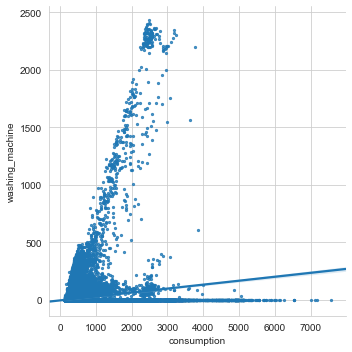

In [145]:
# Washing machine 
sns.set_style("whitegrid")
sns_plot = sns.lmplot(x = "consumption",
           y = "washing_machine", 
           data = data,  
           legend = True, 
           scatter_kws={"s": 5})

It seems that most washing machine consumption and overall consumption couples linearly together (approx y = 0.5x), except when there is no washing machine which impacts our regression fit.  
Note that 3/4 of our dataset actually presents no washing machine consumption at all...

In [5]:
mask = data["washing_machine"]==0
data.shape

(417599, 14)

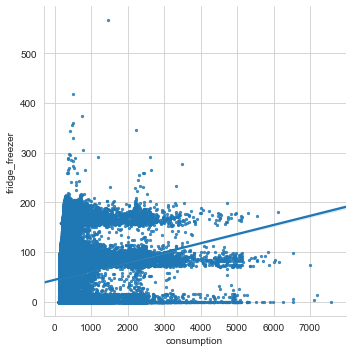

In [146]:
# Fridge_freezer
sns.set_style("whitegrid")
sns_plot = sns.lmplot(x = "consumption",
           y = "fridge_freezer", 
           data = data,  
           legend = True, 
           scatter_kws={"s": 5})

We observe three levels of consumption for our fridge_freezers at any total consumption over 1000W.  
Under 1000W, it would seem that points are equi-distributed. 

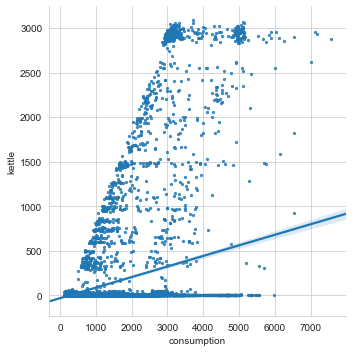

In [147]:
# Kettle
sns.set_style("whitegrid")
sns_plot = sns.lmplot(x = "consumption",
           y = "kettle", 
           data = data,  
           legend = True, 
           scatter_kws={"s": 5})

Again, we observe two very different cases: either kettle consumption is set to zero, either it depends linearly on consumption. 

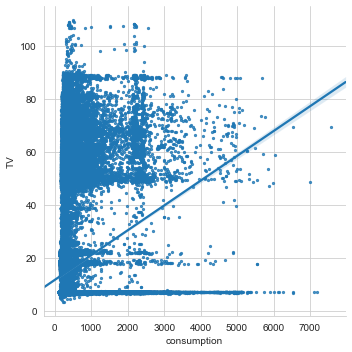

In [148]:
# TV
sns.set_style("whitegrid")
sns_plot = sns.lmplot(x = "consumption",
           y = "TV", 
           data = data,  
           legend = True, 
           scatter_kws={"s": 5})

Relations between TV and overall consumption are more difficult to establish: we seem to have thresholds, once again.

##### b) Then investigating all variables relatively to washing machine since it is the most consuming appliance

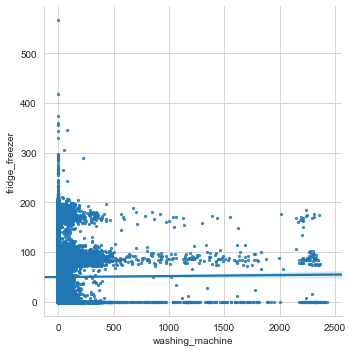

In [141]:
# Case in point with washing_machine and fridge_freezer
sns.set_style("whitegrid")
sns_plot = sns.lmplot(x = "washing_machine",
           y = "fridge_freezer", 
           data = data,  
           legend = True, 
           scatter_kws={"s": 5})

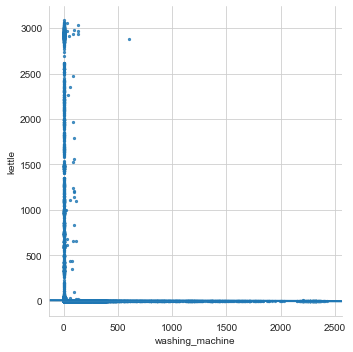

In [142]:
# Case in point with washing_machine and kettle
sns.set_style("whitegrid")
sns_plot = sns.lmplot(x = "washing_machine",
           y = "kettle", 
           data = data,  
           legend = True, 
           scatter_kws={"s": 5})

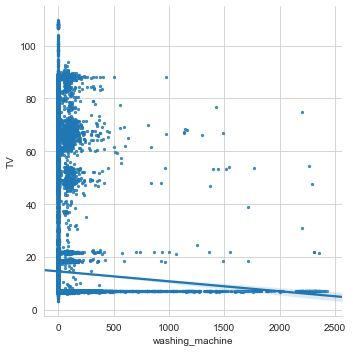

In [143]:
# Case in point with washing_machine and TV
sns.set_style("whitegrid")
sns_plot = sns.lmplot(x = "washing_machine",
           y = "TV", 
           data = data,  
           legend = True, 
           scatter_kws={"s": 5})

###### Simply making the dates exploitable and exploring data along that dimension

We actually have a time-series.

In [10]:
data["time_step"] = pd.to_datetime(data["time_step"])
data.head()

,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure,Unnamed: 9,time_step,washing_machine,fridge_freezer,TV,kettle
0,550.4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-03-17 00:01:00,0.0,79.2000,7.0,0.0
1,548.6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-03-17 00:02:00,0.0,78.0000,7.0,0.0
2,549.3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-03-17 00:03:00,0.0,76.9000,7.0,0.0
3,549.3667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-03-17 00:04:00,0.0,76.1111,7.0,0.0
4,548.8909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-03-17 00:05:00,0.0,75.2727,7.0,0.0


In [11]:
# Segmenting periods
data["month"] = data.apply(lambda x: x["time_step"].month, axis=1)
data["day"] = data.apply(lambda x: x["time_step"].day, axis=1)
data["hour"] = data.apply(lambda x: x["time_step"].hour, axis=1)

# Minuted could be especially valuable
data["minute"] = data.apply(lambda x: x["time_step"].minute, axis=1)
data.head()

,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure,Unnamed: 9,time_step,washing_machine,fridge_freezer,TV,kettle,month,day,hour,minute
0,550.4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-03-17 00:01:00,0.0,79.2000,7.0,0.0,3,17,0,1
1,548.6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-03-17 00:02:00,0.0,78.0000,7.0,0.0,3,17,0,2
2,549.3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-03-17 00:03:00,0.0,76.9000,7.0,0.0,3,17,0,3
3,549.3667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-03-17 00:04:00,0.0,76.1111,7.0,0.0,3,17,0,4
4,548.8909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-03-17 00:05:00,0.0,75.2727,7.0,0.0,3,17,0,5


Let's have a look at our time-series distribution and maybe visualize the data.  
This will allow us to check whether we measure our data uniformly across time. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a22af9748>,
      dtype=object)

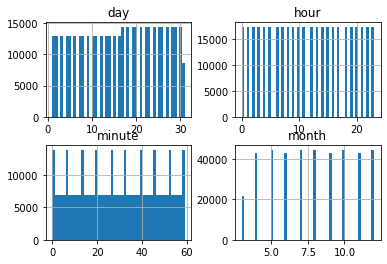

In [12]:
data_dates = data.loc[:,"month":"minute"]
data_dates.hist(bins=50)

In [13]:
data["hour"].value_counts()

23    17400
22    17400
1     17400
2     17400
3     17400
4     17400
5     17400
6     17400
7     17400
8     17400
9     17400
10    17400
11    17400
12    17400
13    17400
14    17400
15    17400
16    17400
17    17400
18    17400
19    17400
20    17400
21    17400
0     17399
Name: hour, dtype: int64

Measures are uniformly spread across hours, which will be useful to create two balanced datasets day/night if need be.

#### I. Initial missing values treatment and data exploration

In [14]:
# We remove 10K observations from our dataset (2.4% of all observations)
mask = data["consumption"].isna()
data = data.drop(data[mask].index)

In [15]:
# Simulating normal distributions for temperature, windchill, and humidex
# Completing NaNs for all of them although we could have dropped 2/3 variables altogether

## Temperature
mean1 = np.nanmean(data["temperature"])
std1 = np.nanstd(data["temperature"])
size1 = data.isna().sum()["temperature"]
temp_simu = np.floor(np.random.normal(mean1, std1, size1))

## Windchill
mean2 = np.nanmean(data["windchill"])
std2 = np.nanstd(data["windchill"])
size2 = data.isna().sum()["windchill"]
windchill_simu = np.floor(np.random.normal(mean2, std2, size2))

## Humidex
mean3 = np.nanmean(data["humidex"])
std3 = np.nanstd(data["humidex"])
size3 = data.isna().sum()["humidex"]
humidex_simu = np.floor(np.random.normal(mean3, std3, size3))

In [16]:
# We replace NaNs in our dataframe
data.loc[:,"temperature"][data["temperature"].isna()] = temp_simu
data.loc[:,"windchill"][data["windchill"].isna()] = windchill_simu
data.loc[:,"humidex"][data["humidex"].isna()] = humidex_simu

# We now check that it worked
data.isna().sum()

consumption             0
visibility         400583
temperature             0
humidity           400583
humidex                 0
windchill               0
wind               400583
pressure           400587
Unnamed: 9         407367
time_step               0
washing_machine         0
fridge_freezer          0
TV                      0
kettle                  0
month                   0
day                     0
hour                    0
minute                  0
dtype: int64

##### a) Baseline missing value treatment using the median

In [17]:
# We affect the median value of each variable to the others as a baseline 
imputer = SimpleImputer(strategy="median")
comp_cols = ["humidity", "visibility", "wind"]

data_comp = data.loc[:, comp_cols]
imputer.fit(data_comp)
X = imputer.transform(data_comp)
data_comp_tr = pd.DataFrame(X, columns=data_comp.columns, index=data_comp.index)
data.loc[:, comp_cols] = data_comp_tr



print(np.nanmean(data["pressure"]), np.nanmedian(data["pressure"]))
mask = data["pressure"].isna()
data["pressure"].loc[mask] = np.nanmedian(data["pressure"])

1010.2137737796786 1013.3


In [18]:
data = data.drop(columns={"Unnamed: 9"})

In [19]:
data.isna().sum()

consumption        0
visibility         0
temperature        0
humidity           0
humidex            0
windchill          0
wind               0
pressure           0
time_step          0
washing_machine    0
fridge_freezer     0
TV                 0
kettle             0
month              0
day                0
hour               0
minute             0
dtype: int64

##### b) Smarter missing value treatment taking time series into account

### II. Feature engineering

Let us differentiate between day and night as this will strongly impact consumption. It could also allow us to train our models on two different datasets if useful. 

In [20]:
# Creating a daytime feature
day_boundaries = [7,20] # defining daytime hours, could segment more precisely 

data["daytime"] = data.apply(lambda x: (x["hour"]in day_boundaries)*1, axis=1)
data.head()

,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure,time_step,washing_machine,fridge_freezer,TV,kettle,month,day,hour,minute,daytime
0,550.4000,23.0,9.0,86.0,15.0,7.0,11.0,1013.3,2013-03-17 00:01:00,0.0,79.2000,7.0,0.0,3,17,0,1,0
1,548.6000,23.0,10.0,86.0,6.0,10.0,11.0,1013.3,2013-03-17 00:02:00,0.0,78.0000,7.0,0.0,3,17,0,2,0
2,549.3000,23.0,11.0,86.0,12.0,11.0,11.0,1013.3,2013-03-17 00:03:00,0.0,76.9000,7.0,0.0,3,17,0,3,0
3,549.3667,23.0,8.0,86.0,9.0,7.0,11.0,1013.3,2013-03-17 00:04:00,0.0,76.1111,7.0,0.0,3,17,0,4,0
4,548.8909,23.0,9.0,86.0,0.0,15.0,11.0,1013.3,2013-03-17 00:05:00,0.0,75.2727,7.0,0.0,3,17,0,5,0


In [96]:
# Creating two day and night datasets to fit different models on 
## Day - Not resetting index to zero, so we can create night dataset
data_day = data[data["hour"] >= day_boundaries[0]]
data_day = data_day[data["hour"] <= day_boundaries[1]]

## Night
data_night = data.drop(data_day.index)
data_night.head()

## Reset indexes
data_day = data_day.reset_index().drop(columns={"index"})
data_night = data_night.reset_index().drop(columns={"index"})

### III. Baseline model

#### a) RandomForestRegressor - 1000 estimators - Part of the dataset

In [21]:
forest_reg = RandomForestRegressor(n_estimators=1000)

In [22]:
# Re-defining the train and test set after our modifications 
y_train = data.loc[:,"washing_machine":"kettle"]
x_train = data.drop(columns={"washing_machine", "kettle", "TV", "fridge_freezer", "time_step"})

## Saving them to csv


In [ ]:
# Extracting a subset


In [ ]:
## Fitting our random forest
forest_reg.fit(x_train, y_train)

In [ ]:
# Storing our predictions
predictions = forest_reg.predict(x_train)

In [ ]:
# Baseline R2
forest_reg.score(x_train, y_train)